[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/application-example/energy_solar_pv.ipynb)

## Renewable Energy: Forecasting hourly solar irradiance
The training will occur on 90% of the data, reserving the last 10% for evaluation.

In [1]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

sf_pv_df = pd.read_csv(data_location + "energy/SF_PV.csv")

### Generic forecast: Time-based features only
In this first section, we will train a model with time-features only like we would do with Facebook Prophet.

From the start, we know that the sun intensity depends on the time of day and season in the year.
Further, we know that the daily peak intensity is proportional to the season. As of now, neither Prophet nor NeuralProphet can multiply two seasonalities, thus, the peak will bee to low in summer and may turn negative in winter. Not ideal, but ok for a first attempt.

In [ ]:
m = NeuralProphet(
    yearly_seasonality=3,
    weekly_seasonality=False,
    daily_seasonality=8,
    growth="off",
    learning_rate=0.1,
)
df_train, df_test = m.split_df(sf_pv_df, freq="H", valid_p=0.10)

metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="bar")

In [5]:
metrics.tail(1)

MAE_val    RMSE_val  Loss_val  RegLoss_val  epoch        MAE  \
108  131.362961  146.889999  0.013868          0.0    108  92.142319   

           RMSE      Loss  RegLoss  
108  118.028023  0.006694      0.0

In [6]:
forecast = m.predict(sf_pv_df)
m.set_plotting_backend("plotly-static")
m.plot(forecast)

Predicting: 247it [00:00, ?it/s]

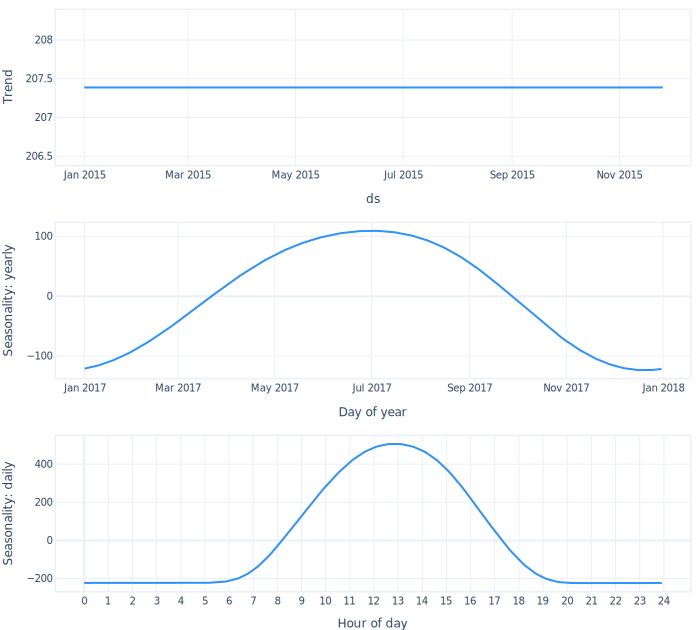

In [7]:
m.plot_parameters()

Predicting: 247it [00:00, ?it/s]

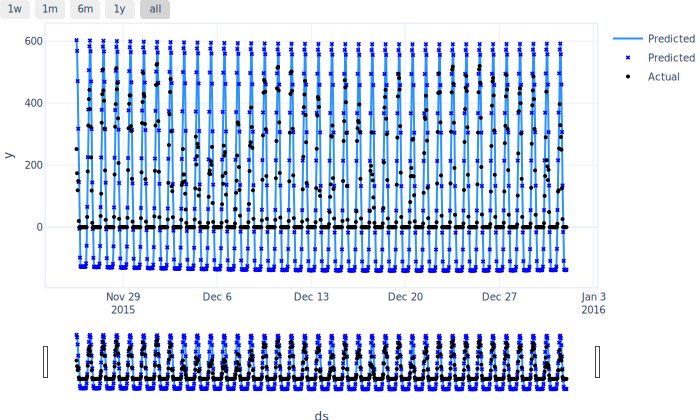

In [8]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

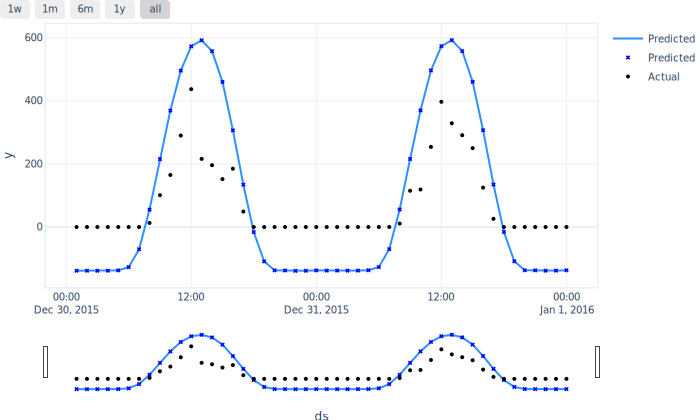

In [9]:
m.plot(forecast[-48:])

### 1-step ahead forecast with Auto-Regresseion
In this second section, we will train a 1-step ahead forecaster on solar irradiance data (that can be a proxy for solar PV production). We can train this forecaster considering the privious 24 steps and disabling trend and seasonality.

The paramters that we can modify are the number of lags and the AR sparsity.

In [ ]:
m = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3 * 24,
    learning_rate=0.01,
)

df_train, df_test = m.split_df(sf_pv_df, freq="H", valid_p=0.10)

metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="bar")

In [11]:
metrics.tail(1)

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
108  18.209431  30.536762  0.000599          0.0    108  30.15587  52.70145   

         Loss  RegLoss  
108  0.001442      0.0

In [12]:
forecast = m.predict(sf_pv_df)
m.set_plotting_backend("plotly-static")
m.plot(forecast)

Predicting: 245it [00:00, ?it/s]

Predicting: 245it [00:00, ?it/s]

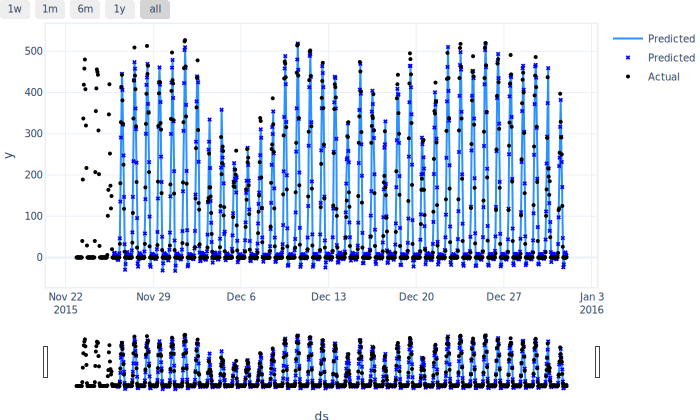

In [13]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

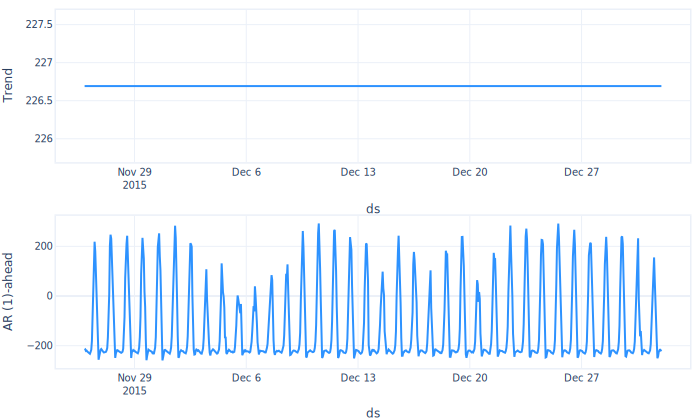

In [14]:
m.plot_components(forecast)

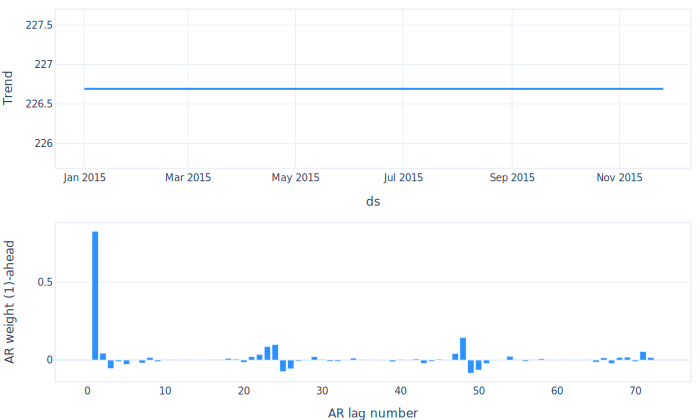

In [15]:
m.plot_parameters()

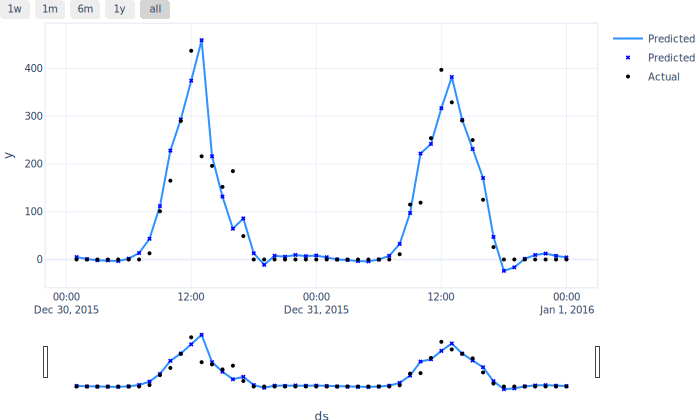

In [16]:
m.plot(forecast[-48:])

### Sparsifying the AR coefficients
By setting an `ar_reg > 0` we can reduce the number of non-zero AR coefficients.

In [ ]:
m = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3 * 24,
    ar_reg=1,
    learning_rate=0.01,
)

df_train, df_test = m.split_df(sf_pv_df, freq="H", valid_p=0.10)

metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="bar")

In [18]:
metrics.tail(1)

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch        MAE      RMSE  \
108  17.369593  31.082371   0.00119     0.000569    108  30.580618  53.85133   

         Loss   RegLoss  
108  0.002069  0.000569

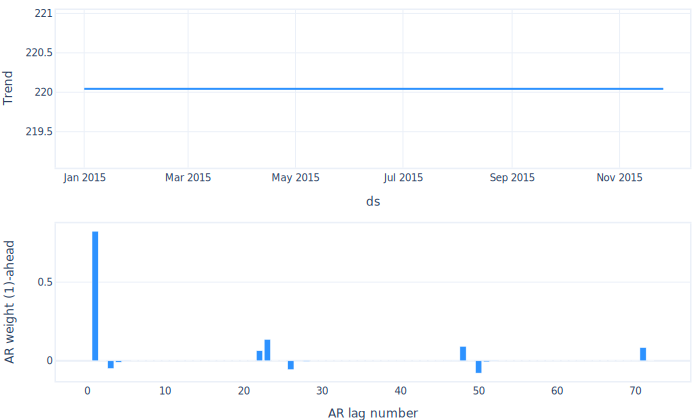

In [19]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.set_plotting_backend("plotly-static")
m.plot_parameters()

### 1-step ahead forecast with Auto-Regression including Integration
Next, we will add the differences of the series as a lagged covariate.
This basically extends the model from AR to ARI, where the I stands for 'integrated' time series.

In [20]:
df = sf_pv_df.copy(deep=True)
df["I"] = np.append(0, sf_pv_df["y"].values[1:] - sf_pv_df["y"].values[:-1])
df.tail(3)

ds  y  I
8757  2015-12-31 22:00:00  0  0
8758  2015-12-31 23:00:00  0  0
8759  2016-01-01 00:00:00  0  0

In [ ]:
m = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3 * 24,
    learning_rate=0.01,
)
m = m.add_lagged_regressor("I", normalize="standardize")
df_train, df_test = m.split_df(df, freq="H", valid_p=0.10)

metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="bar")

In [22]:
metrics.tail(1)

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch        MAE       RMSE  \
108  17.883141  30.405554  0.000594          0.0    108  29.873787  52.650181   

         Loss  RegLoss  
108  0.001445      0.0

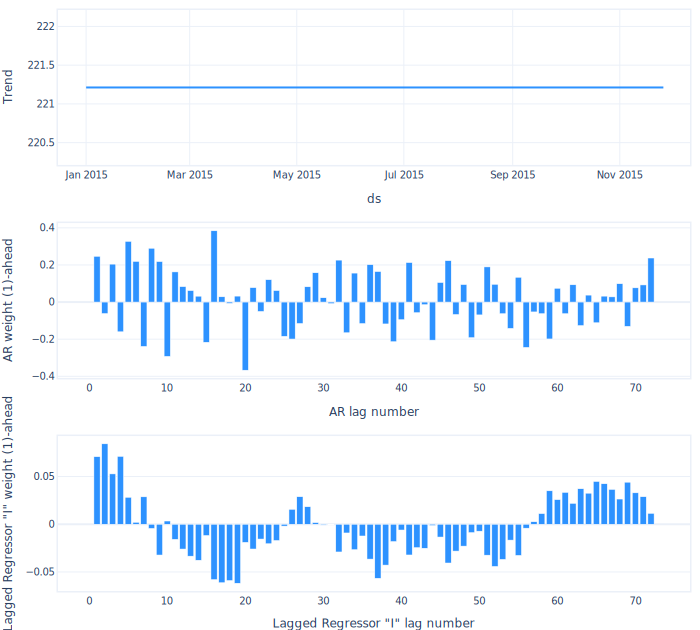

In [23]:
m.set_plotting_backend("plotly-static")
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot_parameters()

### 1 step ahead forecast with AR-Net: Using a Neural Network
There is something to consider here, if we consider a neural network with at least one hidden layer: Learning Rate matters when training a Neural Network.

For a high enough learning rate (probably > 0.1), the gradient seems to vanish and forces the AR net output to 0.
An easy way to void this issue is to set the learning rate at a low enough value, likely around 0.01 to 0.001.

In [ ]:
m = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3 * 24,
    ar_layers=[32, 32, 32, 32],
    learning_rate=0.003,
)

df = sf_pv_df.copy(deep=True)
df["I"] = np.append(0, sf_pv_df["y"].values[1:] - sf_pv_df["y"].values[:-1])
df_train, df_test = m.split_df(df, freq="H", valid_p=0.10)
m = m.add_lagged_regressor("I", normalize="standardize")
metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="bar")

In [25]:
metrics.tail(1)

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch        MAE       RMSE  \
108  14.277524  27.617516   0.00049          0.0    108  21.769081  41.479614   

         Loss  RegLoss  
108  0.000905      0.0

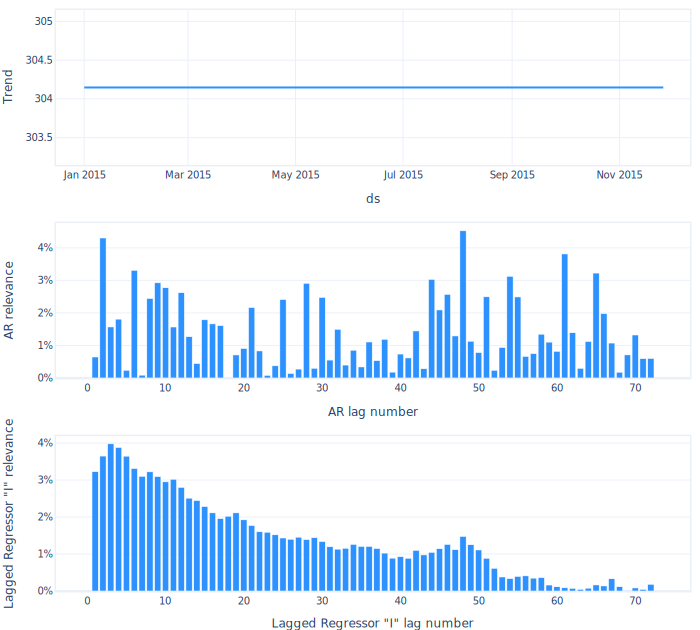

In [26]:
m.set_plotting_backend("plotly-static")
m.plot_parameters()

Predicting: 245it [00:00, ?it/s]

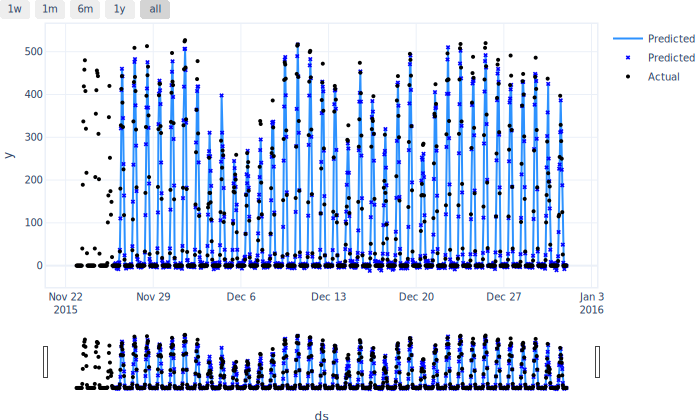

In [27]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
forecast = m.predict(df_test)
m.plot(forecast)

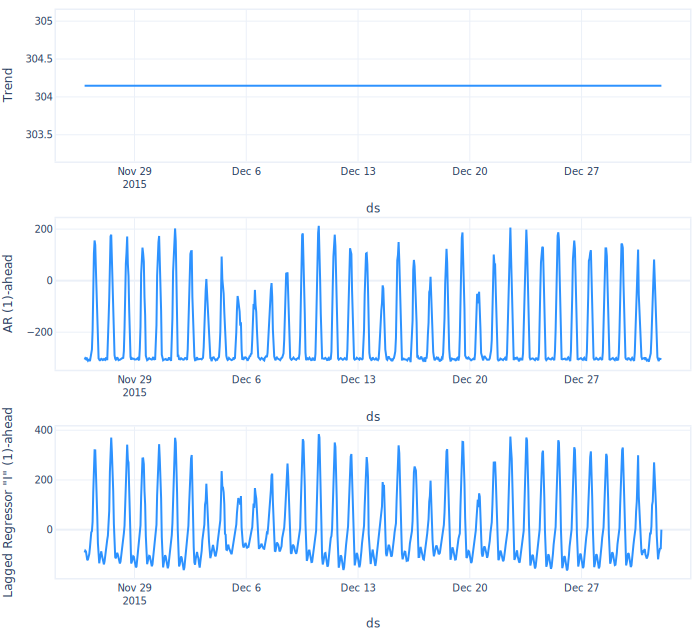

In [28]:
m.plot_components(forecast)

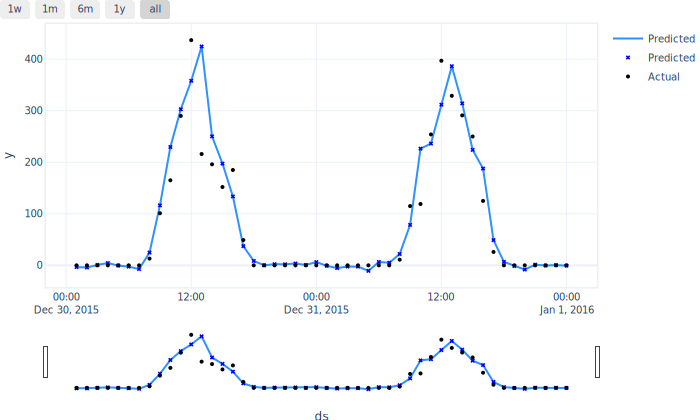

In [29]:
m.plot(forecast[-48:])